# decomp-vorticity-landau.ipynb

This notebook is for the analysis of the vortex-decomposed Gen-2L ensembles in the anisotropy-corrected Landau gauge.

In [1]:
import gluon
import view_gluon

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as so
from inspect import signature

import utils
import gvar as gv

utils.set_mplstyle()

In [2]:
escale = gv.gvar(1.7606,0.0049)  # Gen-2L (spatial) energy scale 1/a_s in GeV
eshift = gv.gvar(7.463,0)  # Gen-2L NRQCD energy shift in GeV (no errors)

Tc = gv.gvar(167,3)  # Gen-2L pseudocritical transition temperature in MeV

XI = gv.gvar(3.453,0.006)  # Gen-2L renormalised anisotropy

available_Nts = [8, 12, 16, 24, 32, 40, 56, 64, 128]
color = [f"C{c}" for c in range(len(available_Nts))]

color_dict = dict(zip(available_Nts,color))

In [3]:
def renorm(q,D_latt,D_tree):
    ### Calculate the renormalizations scale factor from fits to the tree level form (D_tree)
    
    renorm_fit = lambda x,h: h*D_tree
    
    popt,pcov = so.curve_fit(renorm_fit,q,np.asarray([D.mean for D in D_latt]),sigma=np.asarray([D.sdev for D in D_latt]),absolute_sigma=True)
    
    return 1/gv.gvar(popt[0],np.sqrt(pcov[0][0]))

def q_average(q, D, D4=None, q_slices=None):
    ### Average q over each q_slice.

    if q_slices == None and D4 == None:
        return q, D
    elif q_slices == None and D4 != None:
        return q, D, D4
    
    q_avg = []
    D_avg = []
    
    if D4 != None: D4_avg = []
    
    q_pos = 0
    dq = max(q)/q_slices
        
    while q_pos+dq < max(q):
        mask = np.logical_and(q > q_pos, q< q_pos+dq)
        if sum(mask) != 0:
            q_avg.append(np.mean(q[mask]))
            D_avg.append(np.median(D[mask]))
            if D4 != None: D4_avg.append(D4[mask])
                
        q_pos += dq
        
    q = np.asarray(q_avg)
    D = np.asarray(D_avg)
    if D4 != None:
        D4 = np.asarray(D4_avg)
        return q, D, D4
        
    return q, D

## Set Parameters

In [4]:
# Cone cut parameters
radius = 1
angle = np.pi/2 # For cylinder cut, set to None or pi/2.

# q-averaging
q_slices = 100  # Number of momentum slices to average over - set to 'None' for no averaging.

# Plotting parameters

ls = ''  # linestyle
fmt = '.'  # Plot point format
errorevery = 3  # Number of steps between error bars (>1 to show less data)
markevery = errorevery  # Number of steps between data points (>1 to show less data)

plot_params = {'ls':ls,'fmt':fmt,'errorevery':errorevery, 'markevery':markevery}

# Compare modes at fixed temperature

### Read propagator files

In [5]:
Nt = 32

to_TTc = lambda Nt: (1000*escale*XI/Nt)/Tc # Convert between Nt and T/Tc

T = to_TTc(Nt)  # This is Nt in units of T_c

results = {}

for mode in ["UT","VRS","VOS"]: 
    prop = view_gluon.propagator(Nt,mode,n_samples="all",gtype="landau")
    print(Nt,mode, "N_conf = ",len(prop.prop_info))
    raw_q = prop.q
    raw_D = prop.D
    raw_D4 = prop.D4
    
    # Z3 average
    qz3, Dz3, D4z3 = prop.Z3_average(raw_q,raw_D)
        
    prop.q = qz3
    prop.D = Dz3
    prop.D4 = D4z3
    
    qn = prop.norm_q()
    
    prop.q = qn
    
    # Cone cut
    qc, Dc, D4c = prop.cone_cut(radius=radius,angle=angle)
    
    # Lattice momentum correction
    qi = prop.correct_q(qc,qtype="improved")
    
    results[mode] = {'D':prop.D.copy(), 'D4': prop.D4.copy(),'q':qi, 'Nconf':len(prop.prop_info),'prop_info': prop.prop_info,'raw_q':raw_q,'raw_D':raw_D, 'raw_D4':raw_D4}


32 UT N_conf =  48
32 VRS N_conf =  31
32 VOS N_conf =  29


### Plot raw data

This plot shows the raw, unaveraged, uncut, uncorrected (anisotropy) and unrenormalized gluon propagator.

/tmp/ipykernel_900017/3679627117.py:18: RuntimeWarning: divide by zero encountered in divide
  ax.plot(q[sort],1/q[sort]**2,ls='--',c='k',alpha=0.5,label="$\dfrac{1}{q^2}$")


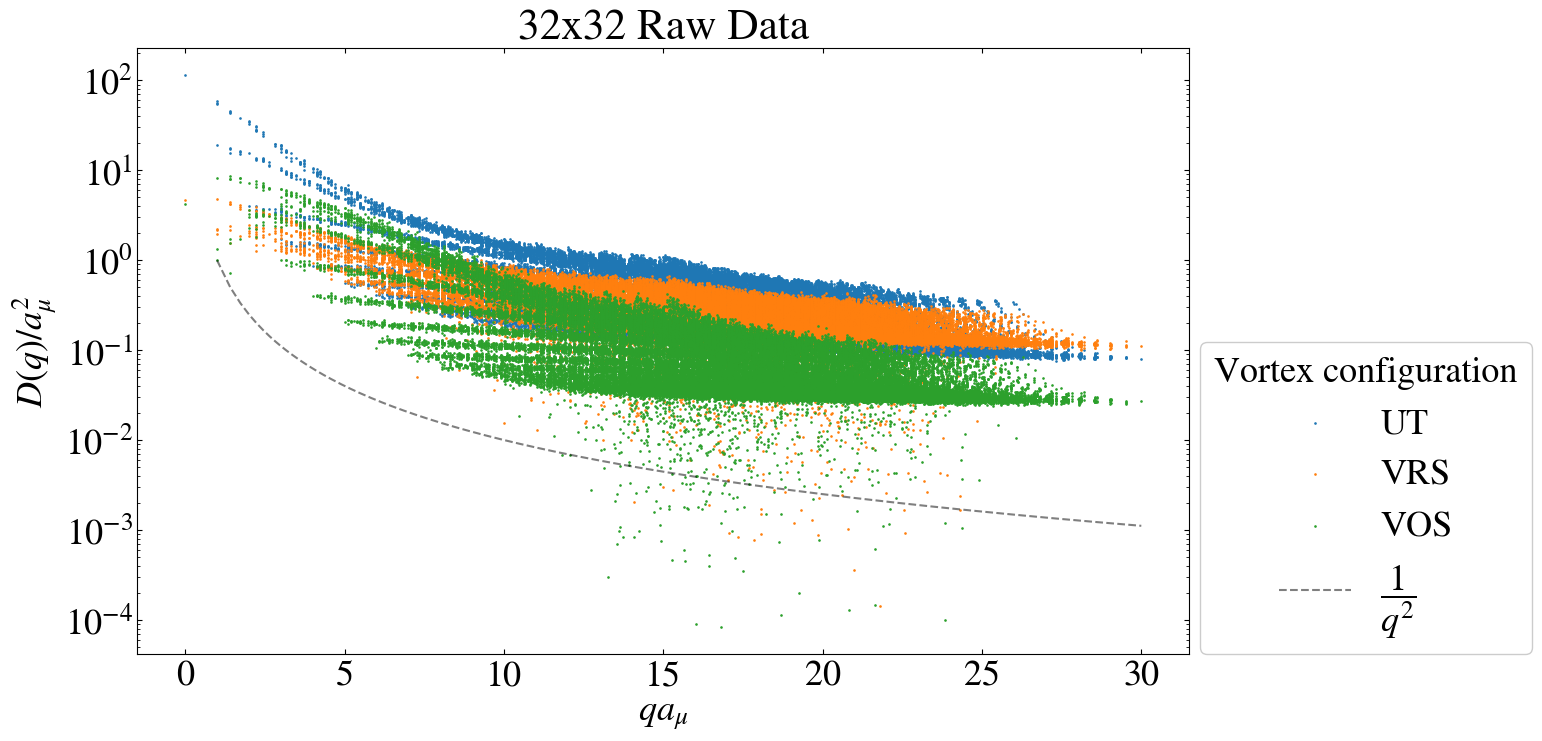

In [6]:
plt.figure(figsize=(16,8))
ax = plt.gca()

for pos,mode in enumerate(results.keys()):
    q = results[mode]['raw_q'].copy()
    q = np.asarray([np.linalg.norm(qi) for qi in q])
    D = results[mode]['raw_D'].copy()
    D4 = results[mode]['raw_D4'].copy()
    
    D = D - XI.mean ** 2 * D4
    
    label = f"{mode}"
    
    ax.scatter(q,np.asarray([d.mean for d in D]),label=label,ls='-',s=0.8)

sort = np.argsort(q)

ax.plot(q[sort],1/q[sort]**2,ls='--',c='k',alpha=0.5,label="$\dfrac{1}{q^2}$")

plt.title(f"{Nt}x32 Raw Data")    
plt.legend(loc=(1.01,0),title='Vortex configuration')
plt.ylabel('$D(q)/a_\mu^2$')
#plt.yticks([])
plt.xlabel('$qa_\mu$')
#plt.ylim(0,6)
plt.yscale('log')

### Plot gluon propagator

This plot shows the gluon propagator with $Z_3$ cubic averaging and a cylinder cut about the BCD and is renormalised to the tree level form $D_{tree}(q)=1/q^2$. Note that in the case of the VOS vortex-only propagator, the renormalization factor is given by the untouched propagator renormalization factor.

UT 0.1381(19)
VRS 0.1131(15)
VOS 0.1381(19)


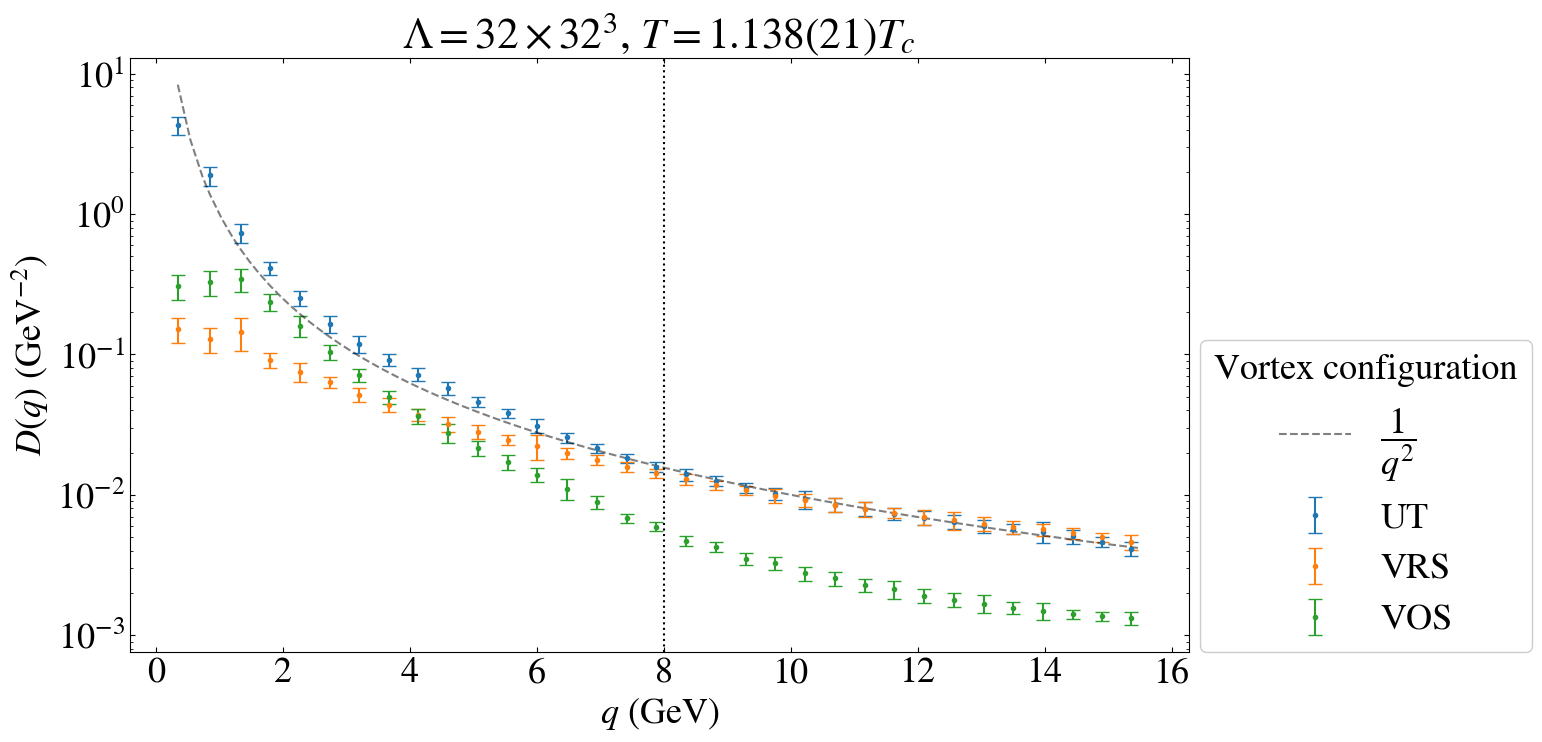

In [7]:
plt.figure(figsize=(16,8))
ax = plt.gca()

renorm_point = 8

modes = list(results.keys())

Z_results = {}  # Renormalization factors

for pos,mode in enumerate(modes):
    
    if mode[0] == "VOS":
        modes.append("VOS")  # If first result is vortex-only, skip for now and return once the Z factors have been calculated.
        continue
    
    q = results[mode]['q'].copy()
    q = np.asarray([np.linalg.norm(qi * np.asarray([XI.mean,1,1,1])) for qi in q]) * escale.mean
    D = results[mode]['D'].copy() / escale.mean**2
          
    q, D = q_average(q, D, D4=None, q_slices=q_slices)
        
    if mode in ["VRS","UT"]:
        Z = renorm(q[q>renorm_point],D[q>renorm_point],1/(q[q>renorm_point]**2))
        
    else: Z = Z_results["UT"]

    Z_results[mode] = Z
        
    print(mode,Z)
    
    D *= Z
    
    label = f"{mode}"
    
    ax.errorbar(q,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,**plot_params)
        
ax.axvline(renorm_point,0,1,ls=':',c='k')

sort = np.argsort(q)

ax.plot(q[sort],1/q[sort]**2,ls='--',c='k',alpha=0.5,label="$\dfrac{1}{q^2}$")

plt.title(f"$\Lambda = {Nt} \\times 32^3$, $T={T}T_c$")    
plt.legend(loc=(1.01,0),title='Vortex configuration')
plt.ylabel('$D(q)$ (GeV$^{-2}$)')
#plt.yticks([])
plt.xlabel('$q$ (GeV)')
#plt.ylim(0,6)
plt.yscale('log')

In [8]:
Z_results

{'UT': 0.1381(19), 'VRS': 0.1131(15), 'VOS': 0.1381(19)}

In [9]:
cache_path = "cache/"

regenerate = False

try:
    if regenerate:
        raise FileNotFoundError
        
    print("Reading from cache...")
    Z_df = pd.read_csv(f"{cache_path}/Z_results.dat",sep=',',index_col=0) 
    
    if Nt not in Z_df.index:
        
        temp_df = pd.DataFrame(Z_results,columns=["UT","VRS","VOS"],index=[Nt])
        Z_df = pd.concat([Z_df,temp_df])
        
        Z_df.to_csv(f"{cache_path}/Z_results.dat",index=True,index_label="Nt")
    
except FileNotFoundError:
    print("No cache file found. Generating...")
    
    Z_df = pd.DataFrame(Z_results,columns=["UT","VRS","VOS"],index=[Nt])
    Z_df.to_csv(f"{cache_path}/Z_results.dat",index=True,index_label="Nt")

Reading from cache...


In [10]:
Z_df

,UT,VRS,VOS
Nt,,,
16,0.1429(26),0.1055(19),0.1429(26)
8,0.1429(28),0.0968(21),0.1429(28)
64,0.1381(20),0.1132(16),0.1381(20)
12,0.1529(23),0.1046(16),0.1529(23)
24,0.1382(19),0.1135(16),0.1382(19)
32,0.1381(19),0.1131(15),0.1381(19)


# Plot renormalization factor

Text(0.5, 0, '$T/T_c$')

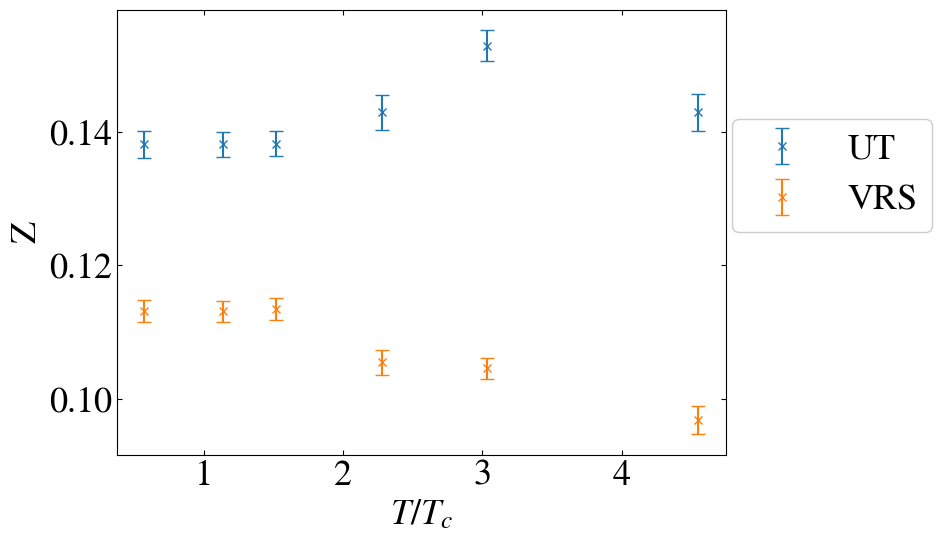

In [11]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

for col_no, mode in enumerate(Z_df.columns):
    
    # Ignore VOS factor
    if mode == "VOS":
        continue
        
    plt.errorbar([to_TTc(i).mean for i in Z_df.index],[z.mean for z in gv.gvar(Z_df[mode].values[:])],[z.sdev for z in gv.gvar(Z_df[mode].values[:])],label=mode,ls='',fmt='x')

ax.legend(loc=(1.01,0.5))
ax.set_ylabel("Z")
ax.set_xlabel("$T/T_c$")

In [12]:
Z_df.index

Int64Index([16, 8, 64, 12, 24, 32], dtype='int64', name='Nt')

UT 0.1381(19)
VRS 0.1131(15)
VOS 0.1381(19)


Text(0.5, 0, '$q$ (GeV)')

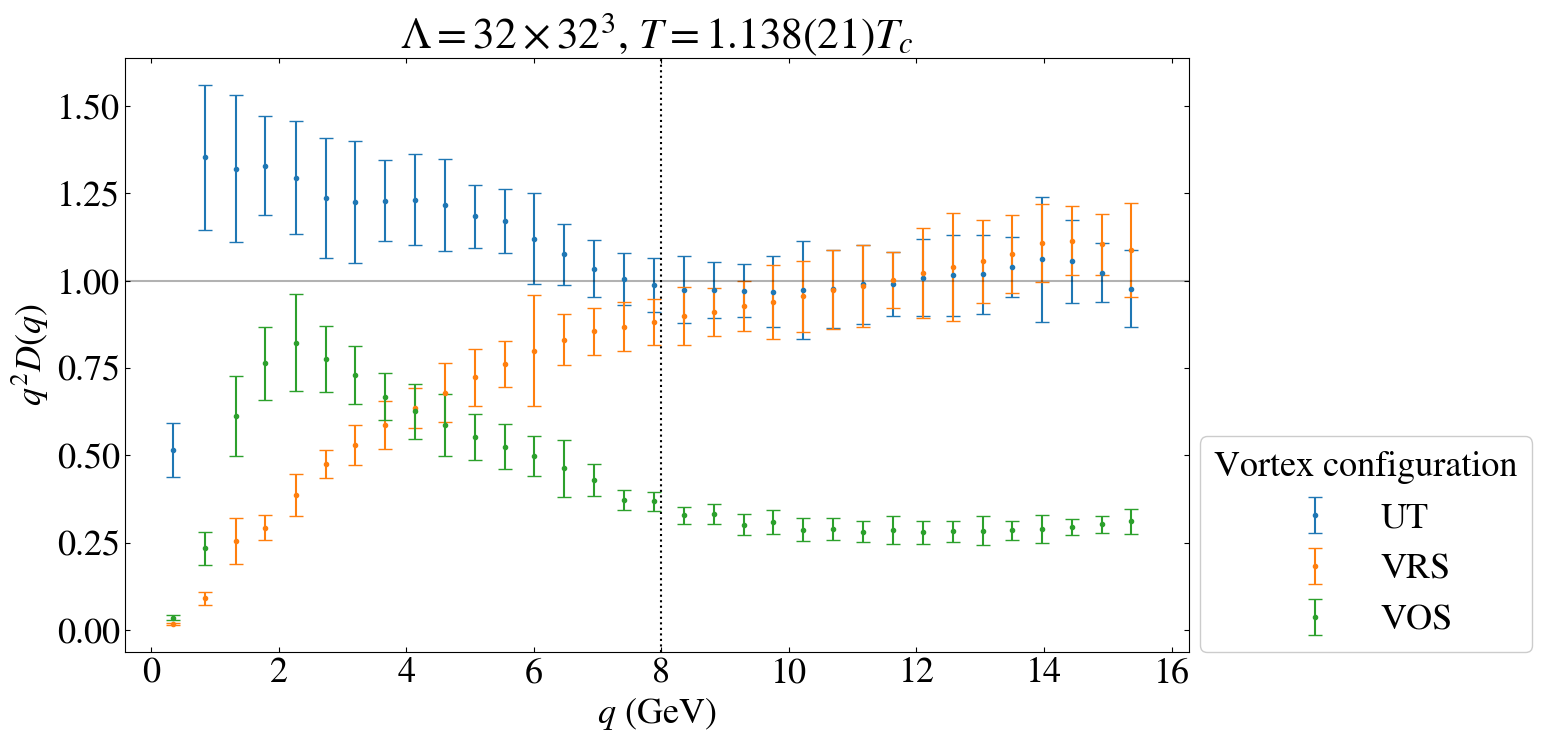

In [13]:
plt.figure(figsize=(16,8))
ax = plt.gca()

renorm_point = 8

modes = list(results.keys())

for pos,mode in enumerate(modes):
    
    q = results[mode]['q'].copy()
    q = np.asarray([np.linalg.norm(qi * np.asarray([XI.mean,1,1,1])) for qi in q]) * escale.mean
    D = results[mode]['D'].copy() / escale.mean**2
            
    Z = gv.gvar(Z_df[mode].loc[Nt])
        
    print(mode,Z)
    
    D *= Z
    
    q, D = q_average(q, D, D4=None, q_slices=q_slices)
    
    label = f"{mode}"
    
    ax.errorbar(q,q**2 * np.asarray([d.mean for d in D]),q**2 * np.asarray([d.sdev for d in D]),label=label,**plot_params)
        
ax.axvline(renorm_point,0,1,ls=':',c='k')
ax.axhline(1,0,1,c='k',alpha=0.3)

sort = np.argsort(q)

plt.title(f"$\Lambda = {Nt} \\times 32^3$, $T={T}T_c$")    
plt.legend(loc=(1.01,0),title='Vortex configuration')
plt.ylabel('$q^2D(q)$')
#plt.yticks([])
plt.xlabel('$q$ (GeV)')
#plt.ylim(0,6)
#plt.yscale('log')

# Reconstructing UT propagator from VOS and VRS

In [14]:
averaged_results = {}

for pos,mode in enumerate(modes):
    
    q = results[mode]['q'].copy()
    q = np.asarray([np.linalg.norm(qi * np.asarray([XI.mean,1,1,1])) for qi in q]) * escale.mean
    D = results[mode]['D'].copy() / escale.mean**2
                    
    q, D = q_average(q, D, D4=None, q_slices=q_slices)
    
    averaged_results[mode] = {'q':q, 'D':D}

Text(0, 0.5, '$q^2D(q)$')

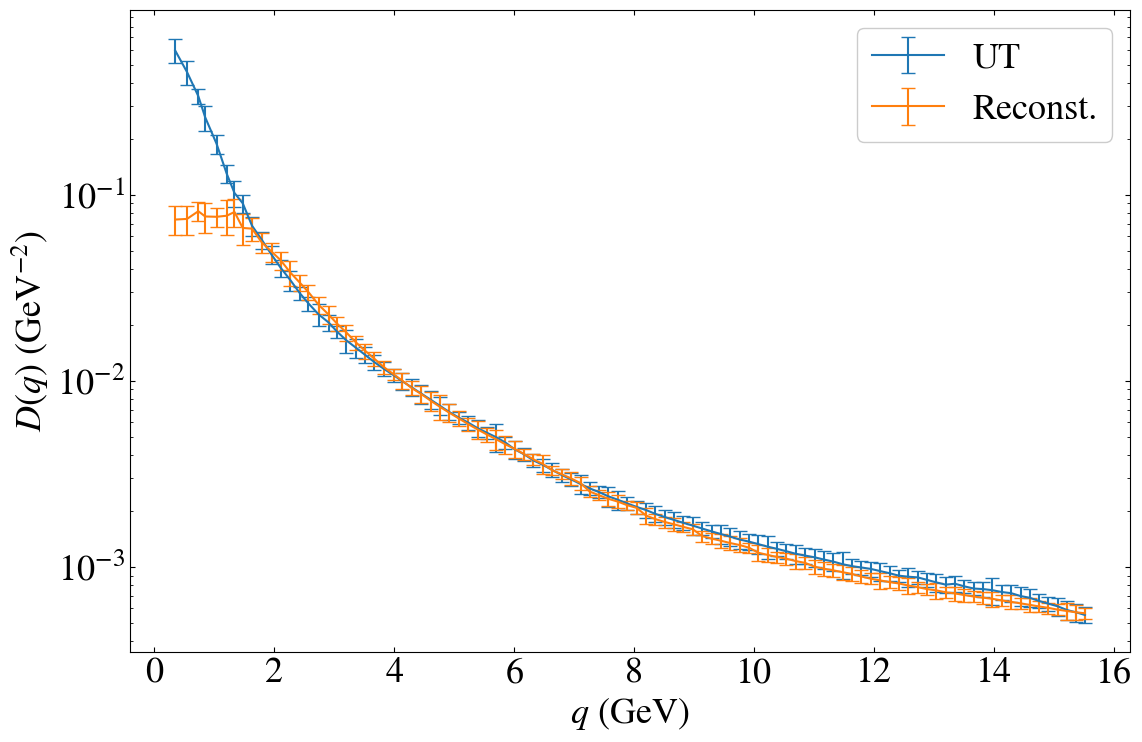

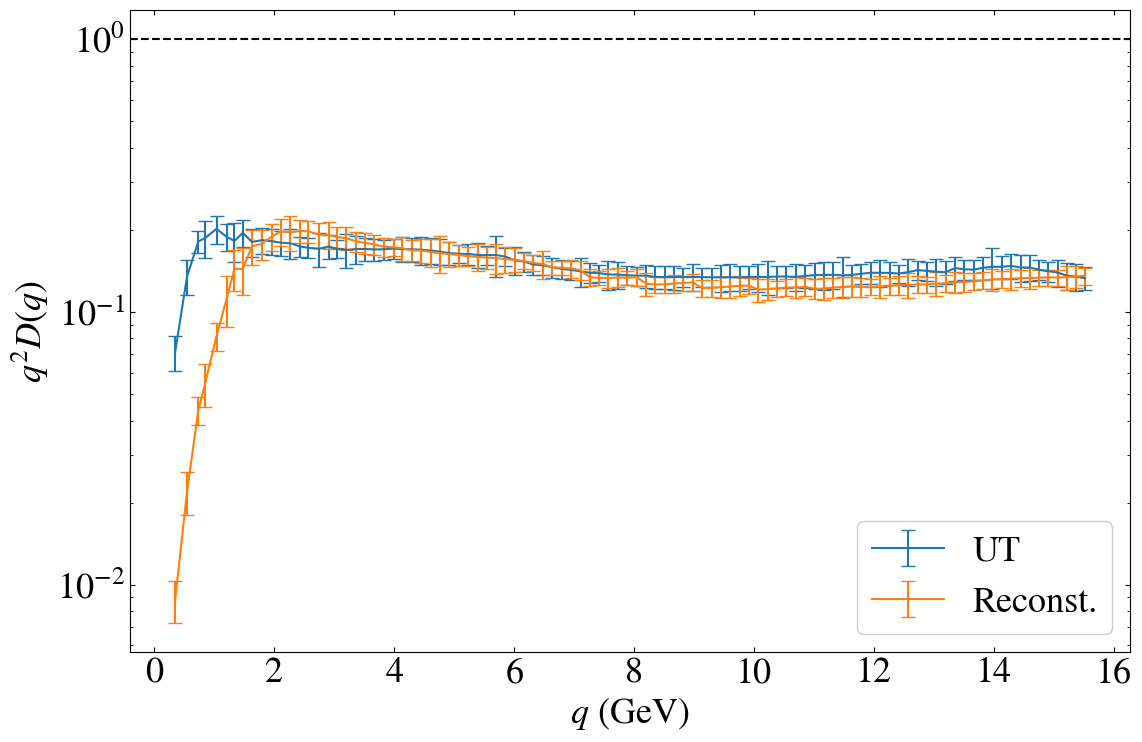

In [16]:
fit_mask = q < 8

q = averaged_results["UT"]['q']

def linear_combfit(q,VOS_Z,VRS_Z):
    VOS_D = np.asarray([d.mean for d in averaged_results["VOS"]['D'][fit_mask]])
    VRS_D = np.asarray([d.mean for d in averaged_results["VRS"]['D'][fit_mask]])
    
    return VOS_Z*VOS_D + VRS_Z*VRS_D

UT_D = averaged_results["UT"]['D'][fit_mask]
UT_D *= gv.gvar(Z_df["UT"].loc[Nt])  # Renormalize

popt,pcov = so.curve_fit(linear_combfit, q[fit_mask], [d.mean for d in UT_D], sigma=[d.sdev for d in UT_D], absolute_sigma=True)
fparams = gv.gvar(popt,pcov)

UT_D = averaged_results["UT"]['D']
UT_D *= gv.gvar(Z_df["UT"].loc[Nt])  # Renormalize

VRS_D = averaged_results["VRS"]['D']
VOS_D = averaged_results["VOS"]['D']

# Plot propagator
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

ax.errorbar(q, [d.mean for d in UT_D],[d.sdev for d in UT_D], label="UT")
ax.errorbar(q, [d.mean for d in fparams[0]*VOS_D + fparams[1]*VRS_D],[d.sdev for d in fparams[0]*VOS_D + fparams[1]*VRS_D], label="Reconst.")

ax.legend()
ax.set_yscale('log')
ax.set_xlabel('$q$ (GeV)')
ax.set_ylabel("$D(q)$ (GeV$^{-2}$)")

# Plot renormalization function
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

ax.errorbar(q, q**2*np.asarray([d.mean for d in UT_D]), q**2*np.asarray([d.sdev for d in UT_D]), label="UT")
ax.errorbar(q, q**2*np.asarray([d.mean for d in fparams[0]*VOS_D + fparams[1]*VRS_D]),q**2*np.asarray([d.sdev for d in fparams[0]*VOS_D + fparams[1]*VRS_D]), label="Reconst.")

ax.axhline(1,ls='--',c='k')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('$q$ (GeV)')
ax.set_ylabel("$q^2D(q)$")

# Compare temperatures

In [17]:
mode = "VOS"

In [18]:
results = {}

for Nt in [8,12,16,24,32,64]:
    try:
        prop = view_gluon.propagator(Nt,mode,n_samples=32,gtype="landau")
    except: continue
    print(Nt,len(prop.prop_info))
    
    q = prop.q
    D = prop.D
    
    # Z3 average
    qz3, Dz3, D4z3 = prop.Z3_average(q,D)
    
    # _,_ = prop.half_cut()
    
    prop.q = qz3
    prop.D = Dz3
    prop.D4 = D4z3
    
    # Calculate the naive momentum
    qn = prop.norm_q()
    
    prop.q = qn
    
    # Cone cut
    qc, Dc, D4c = prop.cone_cut(radius=radius,angle=angle)
    
    # Lattice momentum correction
    qi = prop.correct_q(qc,qtype="improved")
    
    results[Nt] = {'D4':prop.D4.copy(), 'D': prop.D.copy(),'q':qi, 'Nconf':len(prop.prop_info),'prop_info': prop.prop_info}


8 32
12 32
16 32
24 32
32 32
64 32


(2413,) (2413,)
(4568,) (4568,)
(6528,) (6528,)
(9792,) (9792,)
(13056,) (13056,)
(26112,) (26112,)


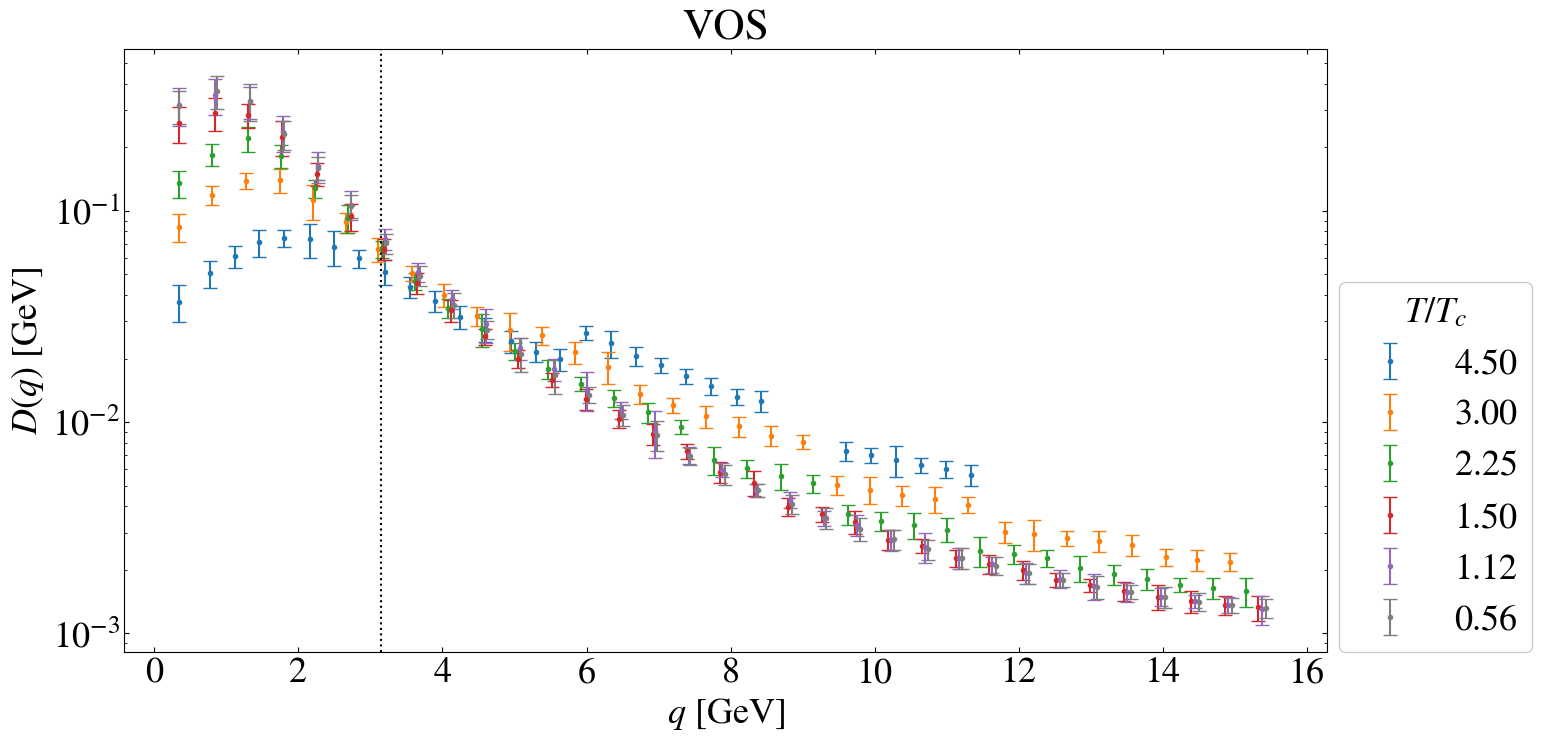

In [19]:
plt.figure(figsize=(16,8))
ax = plt.gca()

for pos,Nt in enumerate(results.keys()):
    q = results[Nt]['q'].copy()
    q = np.asarray([np.linalg.norm(qi * np.asarray([XI.mean,1,1,1])) for qi in q]) * escale.mean
    D = results[Nt]['D'].copy() / escale.mean**2
    
    print(q.shape,D.shape)
    
    Z = gv.gvar(Z_df[mode].loc[Nt])
    D *= Z
    
    label = f"{36/Nt:.2f}"
    
    q, D = q_average(q, D, D4=None, q_slices=q_slices)
    
    ax.errorbar(q,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,c=color_dict[Nt],**plot_params)
    
    if mode in ["UT","VR","VRS"]:
        sort = np.argsort(q)
        ax.plot(q[sort],1/q[sort]**2,c='k',ls='--')
    
ax.axvline(np.pi,0,1,ls=':',c='k')

plt.title(f"{mode}")    
plt.legend(loc=(1.01,0),title='$T/T_c$')
plt.ylabel('$D(q)$ [GeV]')
#plt.yticks([])
plt.xlabel('$q$ [GeV]')
#plt.ylim(0,1)
plt.yscale('log')

(2413,) (2413,)
(4568,) (4568,)
(6528,) (6528,)
(9792,) (9792,)
(13056,) (13056,)
(26112,) (26112,)


Text(0.5, 0, '$q$ [GeV]')

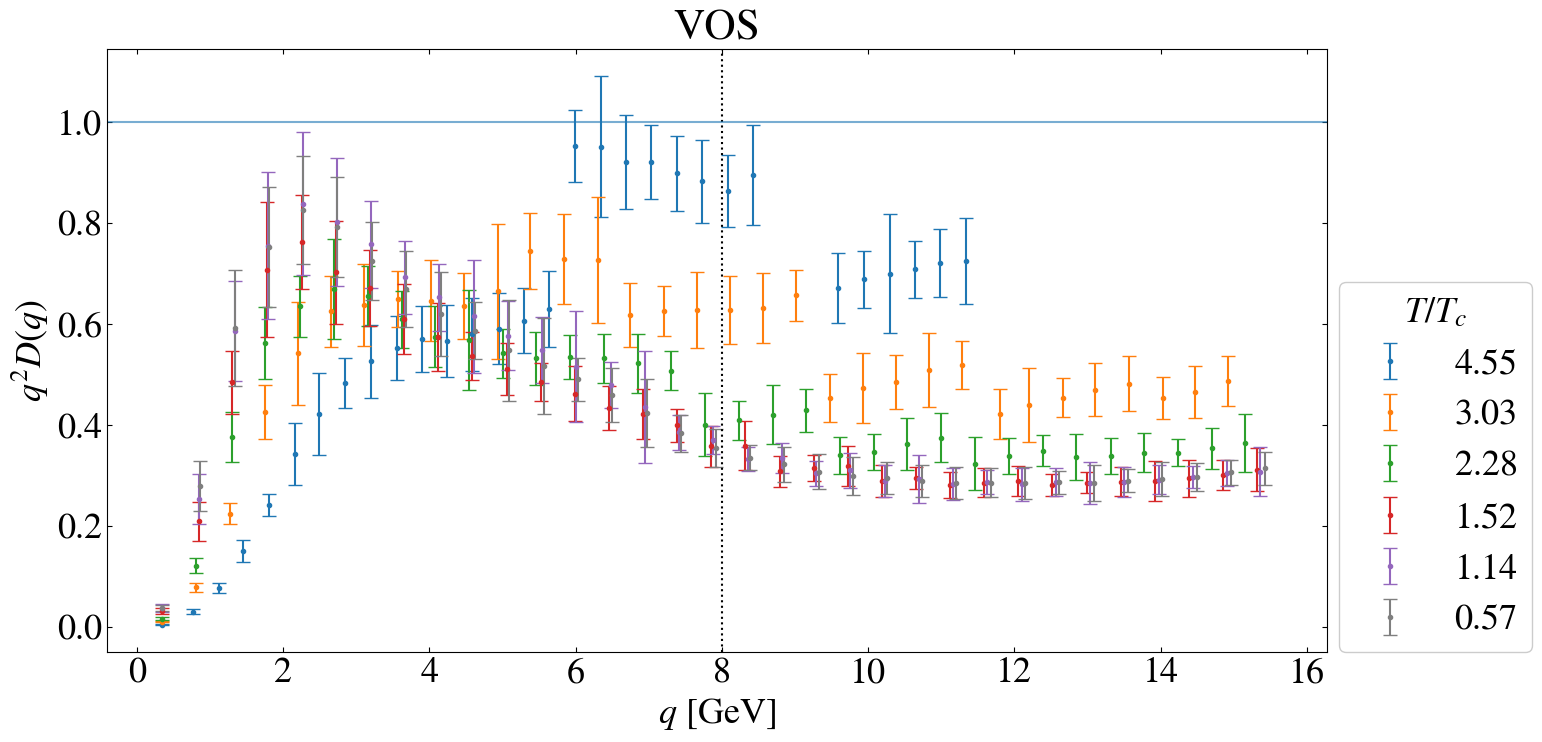

In [20]:
plt.figure(figsize=(16,8))
ax = plt.gca()

for pos,Nt in enumerate(results.keys()):
    q = results[Nt]['q'].copy()
    q = np.asarray([np.linalg.norm(qi * np.asarray([XI.mean,1,1,1])) for qi in q]) * escale.mean
    D = results[Nt]['D'].copy() / escale.mean**2
    
    print(q.shape,D.shape)
    
    Z = gv.gvar(Z_df[mode].loc[Nt])
    
    q, D = q_average(q, D, D4=None, q_slices=q_slices)
    
    D *= Z
    
    ax.errorbar(q,q**2*np.asarray([d.mean for d in D]),q**2*np.asarray([d.sdev for d in D]),label=f"{to_TTc(Nt).mean:.2f}",c=color_dict[Nt],**plot_params)
    
ax.axvline(renorm_point,0,1,ls=':',c='k')
ax.axhline(1,0,1,alpha=0.6)

plt.title(f"{mode}")    
plt.legend(loc=(1.01,0),title='$T/T_c$')
plt.ylabel('$q^2D(q)$')
#plt.yticks([])
plt.xlabel('$q$ [GeV]')
#plt.ylim(0,1)

# Peak fitting

In [21]:
def vo_fit(x,Z,M,b):
    return Z*x/np.sqrt(x**4 + M**4)

def gauss(x,Z,mu,sigma):
    return Z*np.exp(-0.5*((x-mu)/sigma)**2)

In [22]:
fit = view_gluon.marezoni  # available: gribov, stingl, marezoni

N_fparams = len(signature(fit).parameters)-1  # Number of fit parameters

(2413,) (2413,)
2.2355555290428297
(4568,) (4568,)
1.261657036956463
(6528,) (6528,)
0.9472457632436854
(9792,) (9792,)
0.3325478163173307
(13056,) (13056,)
0.15619125791707028
(26112,) (26112,)
0.10723924965422599


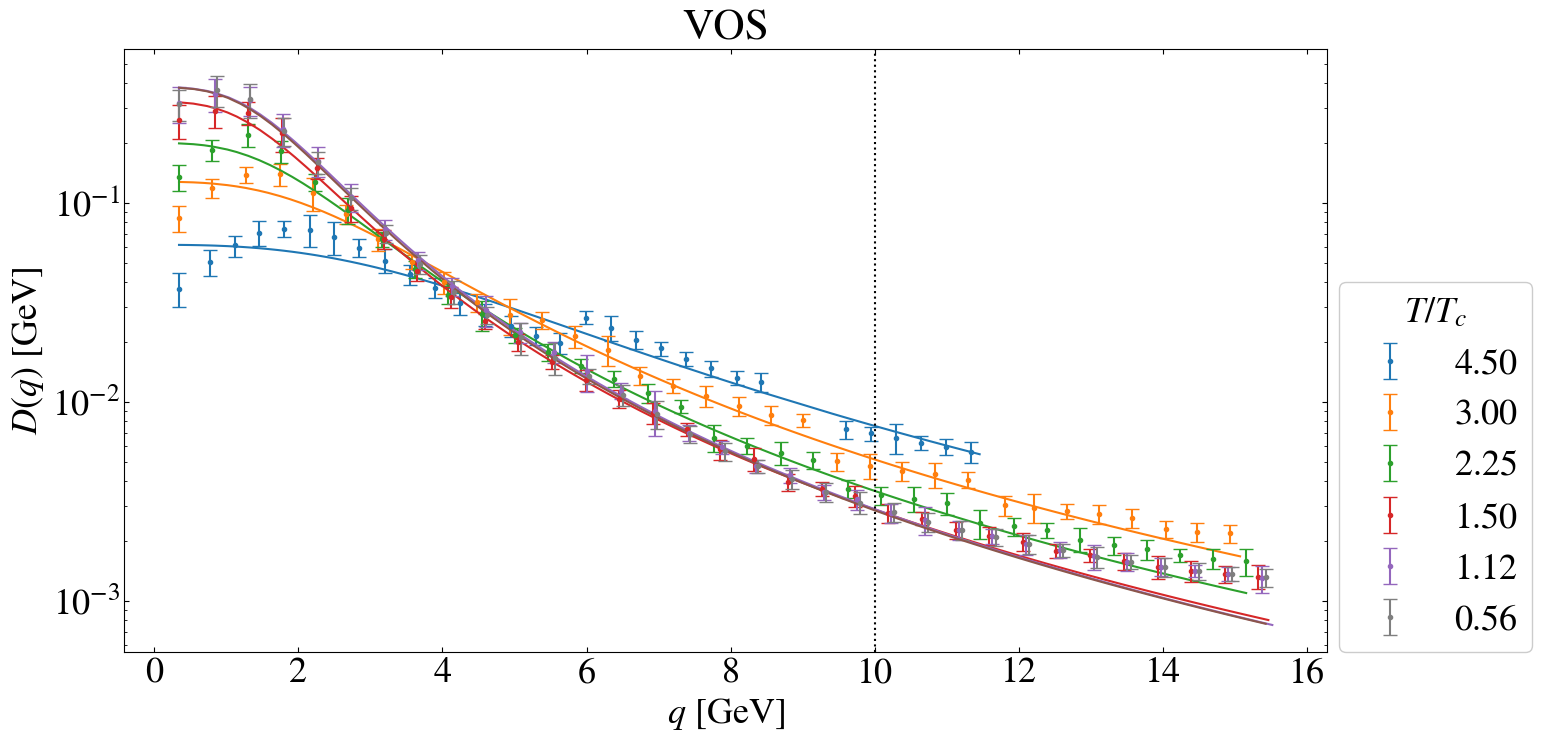

In [23]:
plt.figure(figsize=(16,8))
ax = plt.gca()

fit_results = {}

for pos,Nt in enumerate(results.keys()):
    q = results[Nt]['q'].copy()
    q = np.asarray([np.linalg.norm(qi * np.asarray([XI.mean,1,1,1])) for qi in q]) * escale.mean
    D = results[Nt]['D'].copy() / escale.mean**2
    
    print(q.shape,D.shape)
    
    Z = gv.gvar(Z_df[mode].loc[Nt])
    D *= Z
    
    label = f"{36/Nt:.2f}"
    
    q, D = q_average(q, D, D4=None, q_slices=q_slices)
    
    ax.errorbar(q,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,c=color_dict[Nt],**plot_params)
    
    if mode in ["UT","VR","VRS"]:
        sort = np.argsort(q)
        ax.plot(q[sort],1/q[sort]**2,c='k',ls='--')
    
    # fitting
    
    fit_cut = 10 # change this to alter the fit window
    
    fit_mask = q < fit_cut
    
    try:
        popt, pcov = so.curve_fit(fit,q[fit_mask],[d.mean for d in D[fit_mask]],sigma=[d.sdev for d in D[fit_mask]],absolute_sigma=True)
        
        sort = np.argsort(q)
        
        ax.plot(q[sort],fit(q[sort],*popt))

        chisq = view_gluon.chisq([d.mean for d in D[fit_mask]],fit(q[fit_mask],*popt),[d.sdev for d in D[fit_mask]],ddof=sum(fit_mask)-N_fparams)
        
        print(chisq)
        
        fit_results[Nt] = {"fparams":gv.gvar(popt,pcov), "chisq": chisq}
    except Exception as e:
        print(e)
        
    
ax.axvline(fit_cut,0,1,ls=':',c='k')

plt.title(f"{mode}")    
plt.legend(loc=(1.01,0),title='$T/T_c$')
plt.ylabel('$D(q)$ [GeV]')
#plt.yticks([])
plt.xlabel('$q$ [GeV]')
#plt.ylim(0,1)
plt.yscale('log')

In [24]:
fit_results

{8: {'fparams': array([4.26(92), 0.346(52), 8.3(1.0)], dtype=object),
  'chisq': 2.2355555290428297},
 12: {'fparams': array([3.38(47), 0.400(34), 5.14(44)], dtype=object),
  'chisq': 1.261657036956463},
 16: {'fparams': array([2.71(28), 0.436(27), 3.68(26)], dtype=object),
  'chisq': 0.9472457632436854},
 24: {'fparams': array([2.60(23), 0.476(23), 2.84(18)], dtype=object),
  'chisq': 0.3325478163173307},
 32: {'fparams': array([3.37(32), 0.531(24), 2.97(21)], dtype=object),
  'chisq': 0.15619125791707028},
 64: {'fparams': array([3.16(29), 0.521(24), 2.88(19)], dtype=object),
  'chisq': 0.10723924965422599}}

Text(0, 0.5, '$M$')

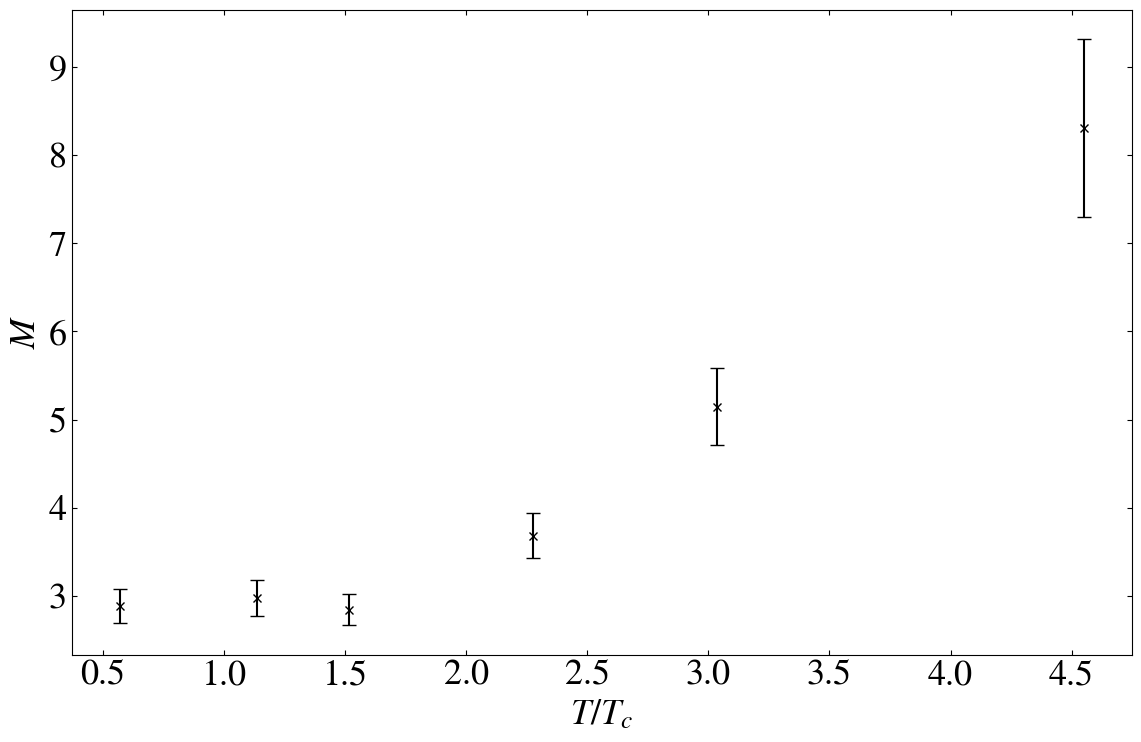

In [25]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

for Nt in results.keys():
    fparams = fit_results[Nt]['fparams'][-1]
    
    plt.errorbar(to_TTc(Nt).mean,fparams.mean,fparams.sdev,fmt='x',c='k')
    
ax.set_xlabel("$T/T_c$")
ax.set_ylabel("$M$")

Text(0, 0.5, '$Z$')

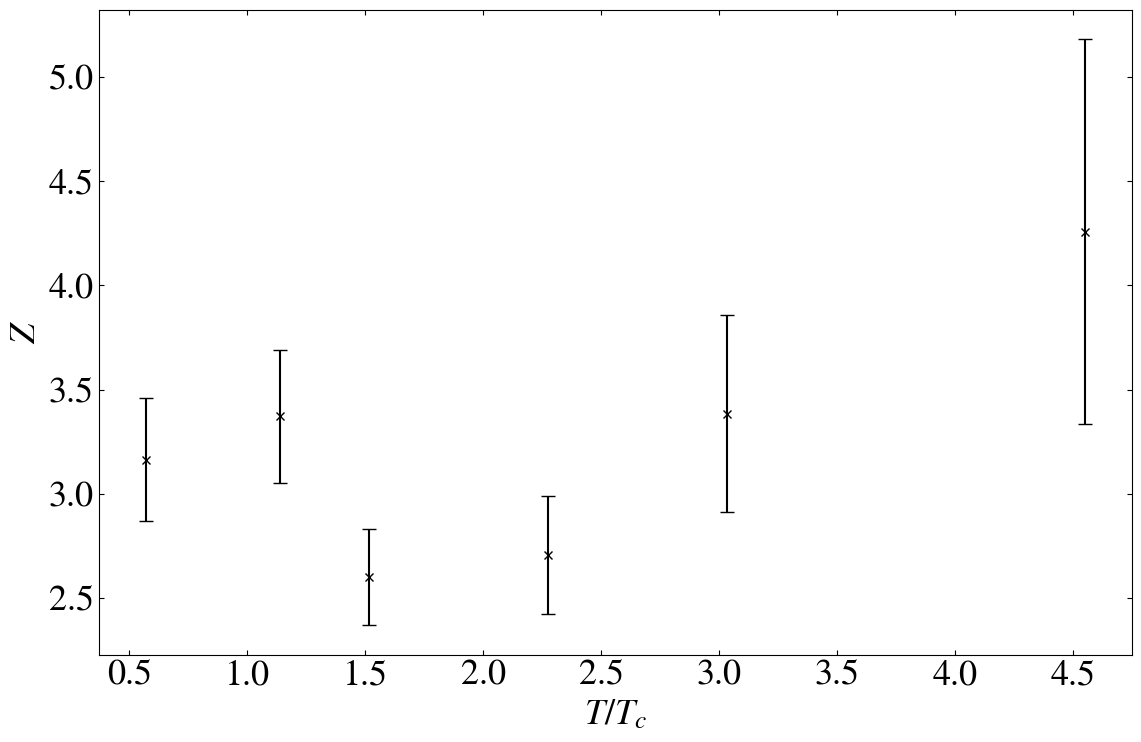

In [26]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

for Nt in results.keys():
    fparams = fit_results[Nt]['fparams'][0]
    
    plt.errorbar(to_TTc(Nt).mean,fparams.mean,fparams.sdev,fmt='x',c='k')
    
ax.set_xlabel("$T/T_c$")
ax.set_ylabel("$Z$")